In [1]:
# Задача исследовать данные stepik об оттоке пользователей курса 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')

In [4]:
df.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
df.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

In [6]:
df.isna().sum()

step_id      0
timestamp    0
action       0
user_id      0
dtype: int64

In [7]:
df.describe()

,step_id,timestamp,user_id
count,3.480703e+06,3.480703e+06,3.480703e+06
mean,3.487358e+04,1.480288e+09,1.331468e+04
std,1.422243e+04,3.068906e+07,7.779099e+03
min,3.045600e+04,1.434341e+09,1.000000e+00
25%,3.217900e+04,1.450271e+09,6.642000e+03
50%,3.292900e+04,1.483904e+09,1.320800e+04
75%,3.348100e+04,1.507889e+09,2.014400e+04
max,1.584330e+05,1.526773e+09,2.679800e+04


In [8]:
df.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [9]:
df['Datetime'] = pd.to_datetime(df.timestamp, unit='s')

In [10]:
print(df.Datetime.min(), df.Datetime.max())

2015-06-15 04:00:48 2018-05-19 23:33:31


In [11]:
df['Day'] = df.Datetime.dt.date

In [12]:
uniq_by_date = df.groupby('Day').user_id.nunique().reset_index()

<Axes: xlabel='Day', ylabel='user_id'>

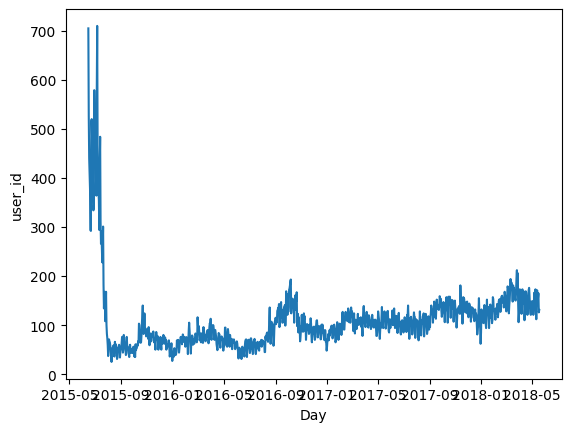

In [13]:
sns.lineplot(uniq_by_date, x='Day', y='user_id')

<Axes: >

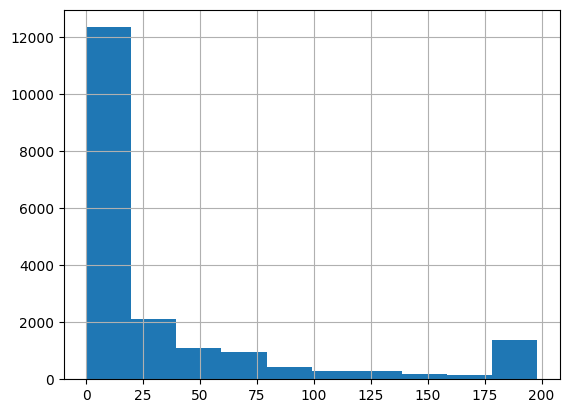

In [14]:
df.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().passed.hist()

In [15]:
user_events = df.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [16]:
sub_df = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [17]:
sub_df.isna().sum()

step_id              0
timestamp            0
submission_status    0
user_id              0
dtype: int64

In [18]:
sub_df['Datetime'] = pd.to_datetime(sub_df.timestamp, unit='s')

In [19]:
sub_df['Date'] = sub_df.Datetime.dt.date

In [20]:
users_subs = sub_df.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().sort_values('correct', ascending=False)

In [21]:
gaps_data = df[['user_id', 'timestamp', 'Day']].drop_duplicates(subset=['Day']).groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [22]:
gaps_data = pd.Series(np.concatenate(gaps_data, axis=0))

In [23]:
gaps_data.quantile(0.90) / (24*60*60)

np.float64(15.203456018518562)

In [24]:
users = df.groupby('user_id').agg({'timestamp':'max'}).reset_index()

In [25]:
users = users.merge(users_subs, on=['user_id'], how='left')
users.fillna(0, inplace=True)

In [26]:
users = users.merge(user_events, on='user_id', how='left')
users.fillna(0, inplace=True)

In [27]:
uniq_days = df.groupby('user_id').agg({'Day':'nunique'}).reset_index().rename(columns={'Day':'days_unique'})

In [28]:
users = users.merge(uniq_days, on='user_id', how='left')
users.fillna(0, inplace=True)

In [29]:
users['churned'] = np.where(((1526772811 - users.timestamp) > 24*60*60*30) & (users.passed < 170), 1, 0)

In [30]:
users['finished_course'] = np.where(users.passed > 170, 1,0)

In [33]:
#сколько в среднем дней потребовалось пользователям, которые прошли курс

users[users.finished_course == 1].days_unique.median()

np.float64(20.0)

<Axes: >

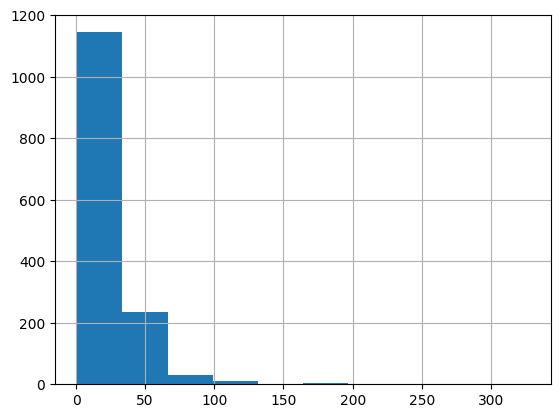

In [36]:
users[users.finished_course == 1].days_unique.hist()

In [37]:
#отбираем события, которые произошли от времени регистрации пользователя + 3 дня

In [53]:
df_min = df.merge(df.groupby('user_id').agg({'timestamp':'min'}).rename(columns={'timestamp':'min_timestamp'}).reset_index(), on='user_id', how='left')

In [54]:
threshold = 3*24*60*60

In [67]:
events_train = df_min[df_min.timestamp < df_min.min_timestamp + threshold]

In [58]:
#найдем степы, на которых пользователи отваливались
df_max = sub_df.merge(sub_df.groupby('user_id').agg({'timestamp':'max'}).rename(columns={'timestamp':'max_timestamp'}).reset_index(), on='user_id', how='left')

In [66]:
df_max[(df_max.timestamp == df_max.max_timestamp) & (df_max.submission_status == 'wrong')].groupby('step_id') \
    .agg({'user_id':'count'}).reset_index().sort_values('user_id', ascending=False)

,step_id,user_id
4,31978,154
28,32812,133
11,32031,97
19,32202,92
42,33481,78
...,...,...
43,33482,1
59,33686,1
57,33684,1
55,33676,1


In [73]:
# проверяем корректность. 4 дня ок – так как пользователь первое событие мог начать в середине дня
events_train.groupby('user_id').Day.nunique().max()

np.int64(4)

In [74]:
sub_train =  sub_df.merge(sub_df.groupby('user_id').agg({'timestamp':'min'}).rename(columns={'timestamp':'min_timestamp'}).reset_index(), on='user_id', how='left')

In [76]:
sub_train = sub_train[sub_train.timestamp < sub_train.min_timestamp + threshold]

In [81]:
#аналогично проверяем
sub_train.groupby('user_id').Date.nunique().max()

np.int64(4)

In [166]:
# Подготовим датафрейм для обучения
X = sub_train.groupby('user_id').Date.nunique().to_frame().reset_index()

In [167]:
steps_tried = sub_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id':'steps_tried'})

In [168]:
X = X.merge(steps_tried, on = 'user_id', how='left')

In [169]:
users_subs = sub_train.pivot_table(index='user_id', 
                                    columns='submission_status', 
                                    values='step_id', aggfunc='count', 
                                    fill_value=0) \
    .reset_index()

In [170]:
X = X.merge(users_subs, on = 'user_id', how='left')

In [171]:
X['correct_ratio'] = X.correct / (X.correct+ X.wrong)

In [172]:
X = X.merge(events_train.pivot_table(index='user_id', 
                           columns='action', 
                           values='step_id', 
                           aggfunc='count', fill_value=0) \
                            .reset_index()[['user_id','viewed']], 
            on='user_id', how='outer')

In [173]:
X.fillna(0, inplace=True)

In [174]:
X = X.merge(users[['user_id','finished_course','churned']], on='user_id', how='outer', )

In [175]:
X = X[~((X.churned == 0) & (X.finished_course == 0))]

In [176]:
y = X.finished_course

In [177]:
X = X.drop(columns=['finished_course','churned'])

In [180]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)